In [121]:
from itertools import chain
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [122]:
# fetch dataset 
iris = fetch_ucirepo(id=53) 
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 

## Probability Density Function for a Normal Distribution

In [123]:
def pdf_normal(x, axis=0):
    mean, std = np.mean(np.array(x), axis=axis), np.std(np.array(x), axis=axis)
    return lambda x: np.exp(-0.5*((x - mean)/std)**2)/(std*np.sqrt(2*np.pi)) 

## Numeric Integrator

In [124]:
def euler(x0=0, dt=0, dy=0, steps=-1, thr=1e-3):
    steps = int(thr/dt) if steps < 1 else steps
    value = np.zeros_like(x0)
    for step in range(steps):
        x0 = x0 + dt
        value = value + dt*dy(x0)

    return value

## Class Conditional Probability Function
A vectorized function, that computes the PDF (Probability Density) and integrates the PDF over an interval $x_i + \Delta_x$ to approximate the conditonal probability $P(x_i | w_j)$

In [125]:
def prob_dist(feature, thr=1e-3):
    return lambda x: euler(x0=x, dy=pdf_normal(feature), dt=1e-5, thr=thr)

## Example

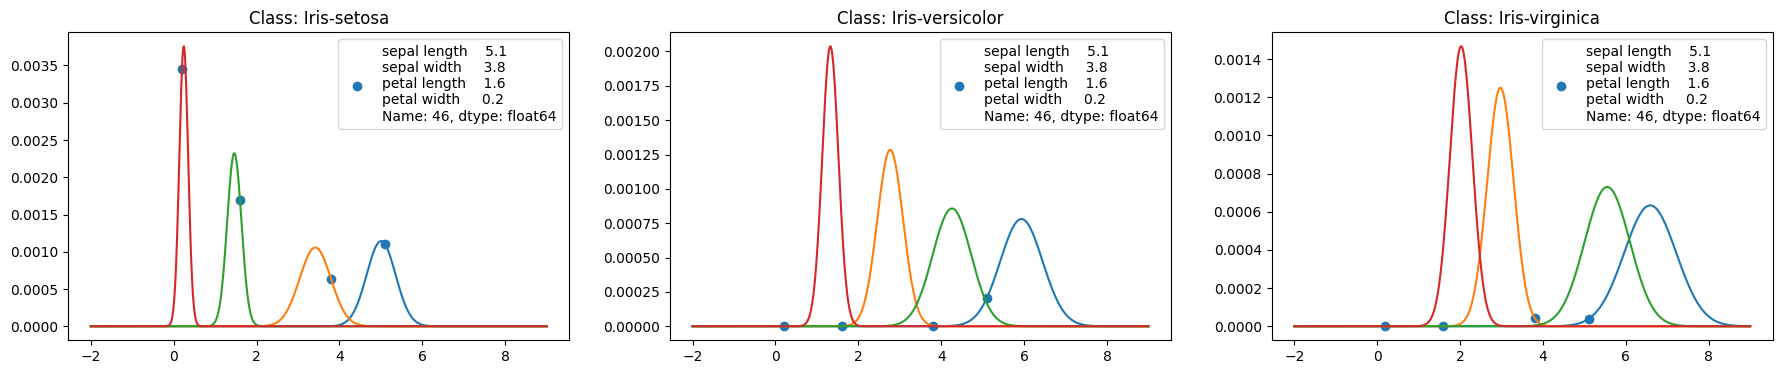

In [126]:
fig, axes = plt.subplots(1, 3, figsize=(22, 4))
groups = list(y.groupby('class').groups.values())
a, c = 5, 1000
arr = np.linspace(-a + 3, a + 4, c)
arrr = np.vstack([arr, arr, arr, arr]).transpose()
test = X.iloc[np.random.randint(0, len(X))]
for _ in range(len(axes)):
    features = X.iloc[groups[_]]
    func =  prob_dist(feature=features, thr=1e-3)
    axes[_].plot(arr, func(arrr))
    axes[_].scatter(test, prob_dist(feature=features, thr=1e-3)(np.array(test)), label=str(test))
    axes[_].set_title(f'Class: {y.iloc[groups[_]].iloc[0].values[0]}')
    axes[_].legend()
plt.show()

In [127]:
class NaiveBayes:
    def __init__(self):
        pass
    
    def _prob_class_conditional(self):
        pass
    
    def _prob_total(self):
        pass
    
    def _prob_class(self):
        pass
    
    def decision_rule(self, X, class_prob):
        pass
    
    def fit(self, x: pd.DataFrame, y: pd.DataFrame):
        if not isinstance(X, pd.DataFrame) or not isinstance(y, pd.DataFrame):
            raise TypeError(f'X is type {type(x)} must be {pd.DataFrame}, y is type {type(y)} must be {pd.DataFrame}')
        
        # Compute the prior for the class probabilities 
        class_probabilities = y.value_counts()/len(y) 
        
        # Extract the classes
        classes = list(chain(*class_probabilities.index))
        
        # Extract indices
        groups = list(y.groupby(list(y.columns)).groups.values())
    
        
nb = NaiveBayes()
nb.fit(x=X, y=y)